# MITRE + OWASP Threat Modelling

In this demo, we will use a graph built from MITRE and OWASP data sources to create a list of security requirements ([OWASP ASVS](https://owasp.org/www-project-application-security-verification-standard/)) based on the consequences ([MITRE CAPEC](https://capec.mitre.org/)) we want to avoid.

To run this demo, you need to build the graph, in this repo there is a 'source' folder, in here are three data routines to be run in order:
- 01 acquire_rawdata.py
- 02 process_rawdata.py
- 03 build_graph.py

These download, transform and build into a grpah.

In [1]:
# import libraries we will use
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import mitretools as mt

In [2]:
# simple routine to help with display
def log(items):
    for key in items:
        print(key)

In [3]:
# load the precompiled graph (you will need to build this)
graph = nx.read_graphml(r'data/processed/mitre-data.graphml')
print('nodes:', len(graph.nodes()))
print('edges:', len(graph.edges()))

nodes: 3128
edges: 10172


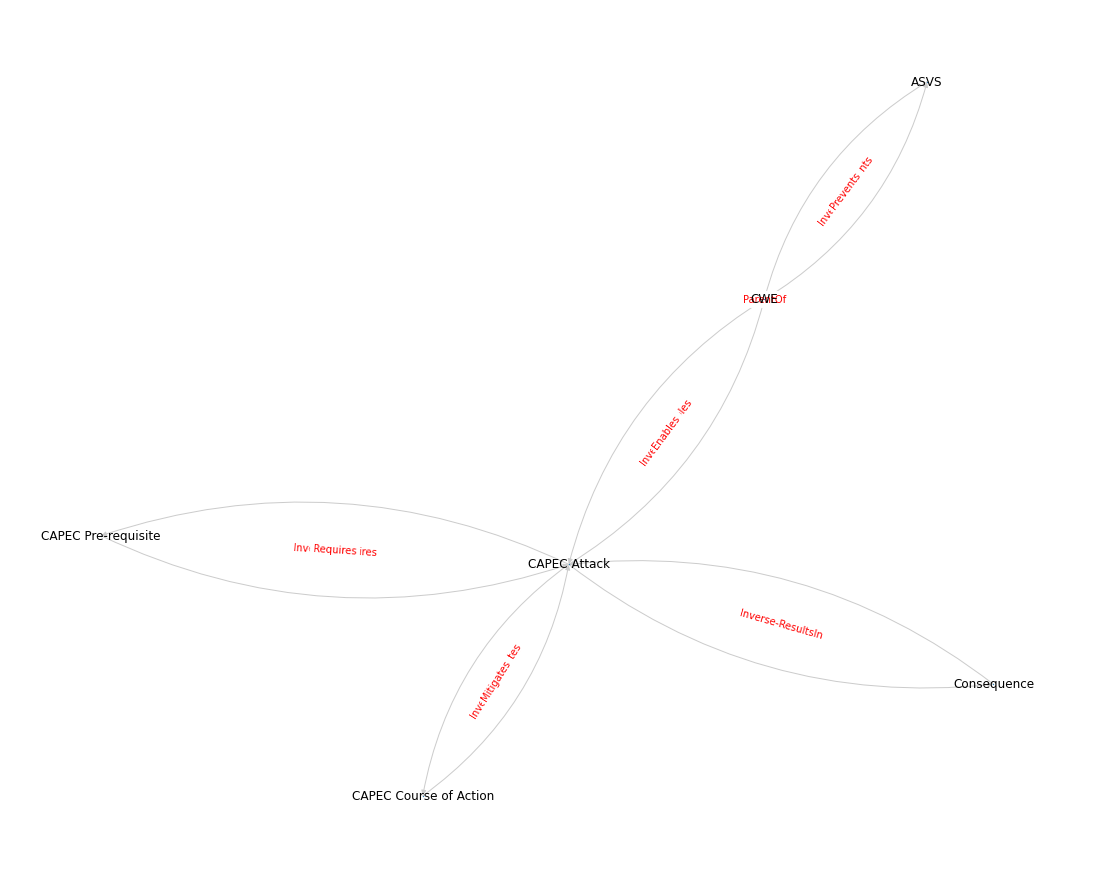

In [4]:
# condense and draw the node and edge types
condensate = mt.remove_orphans(graph)
condensate = mt.condense_graph(condensate)

mt.show_graph(condensate)

CAPEC references are mapped to Consequences (exploit of a CAPEC ResultsIn a Consequence), Courses of Action (Courses of Action Mitigates exploitation of a CAPEC), CWEs (CWEs are weaknesses which Enables exploitation of a CAPEC). CWEs in turn map to ASVS (ASVS describe how to test if there is a Weakness).

This allows us to build a mapping from Consequences to ASVS.

In [5]:
# list all of the potential consequences

consequences = mt.select_nodes_by_type(graph, ['Consequence'])
log(mt.list_nodes(consequences, ['group', 'consequence']))

Confidentiality, Gain Privileges
Access_Control, Gain Privileges
Authorization, Gain Privileges
Availability, Unreliable Execution
Availability, Execute Unauthorized Commands
Confidentiality, Execute Unauthorized Commands
Confidentiality, Read Data
Integrity, Execute Unauthorized Commands
Integrity, Modify Data
Confidentiality, Modify Data
Availability, Resource Consumption
Confidentiality, Bypass Protection Mechanism
Access_Control, Bypass Protection Mechanism
Authorization, Bypass Protection Mechanism
Confidentiality, Other
Authorization, Execute Unauthorized Commands
Accountability, Gain Privileges
Authentication, Gain Privileges
Non-Repudiation, Gain Privileges
Integrity, Gain Privileges
Integrity, Other
Availability, Other
Access_Control, Execute Unauthorized Commands
Integrity, Alter Execution Logic
Integrity, Hide Activities
Integrity, Read Data
Availability, Alter Execution Logic
Confidentiality, Alter Execution Logic
Confidentiality, Hide Activities
Access_Control, Hide Activi

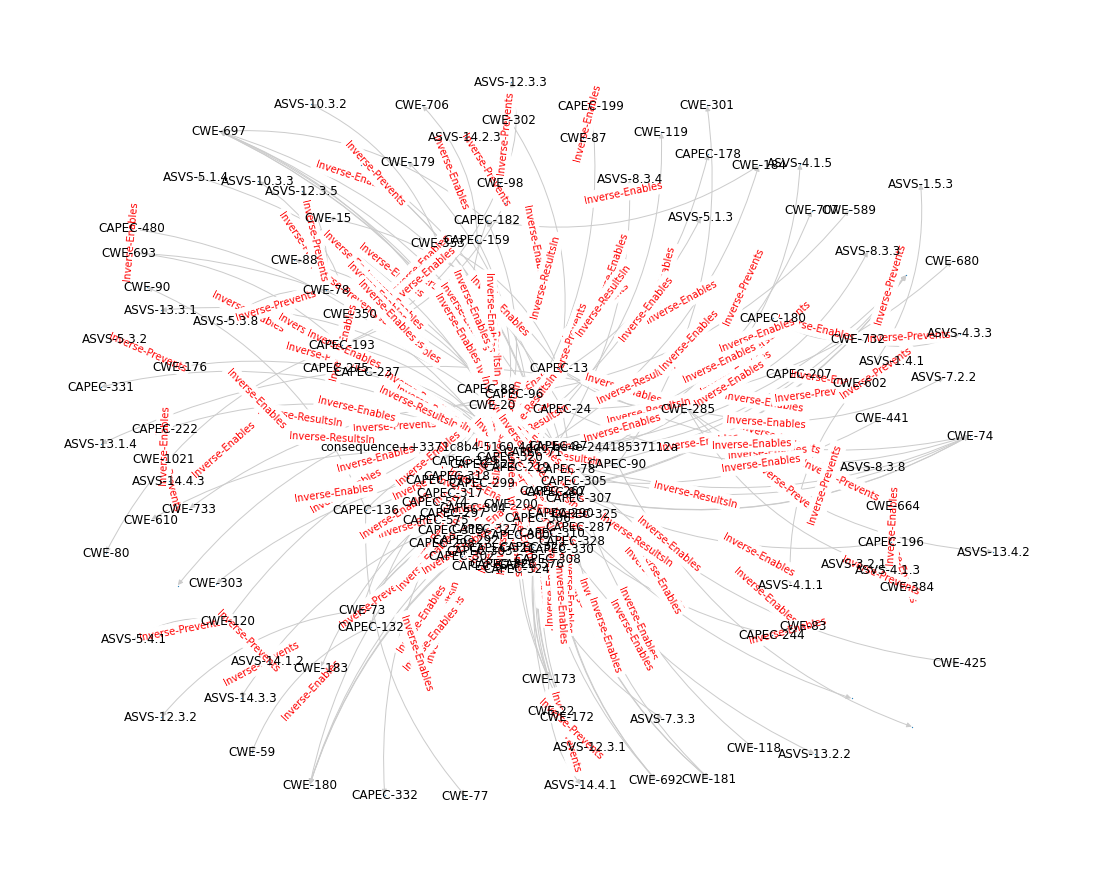

In [6]:
# For this example, we're interested in preventing Authorization issues by Bypassing Protection Mechanisms
# To filter the tree, we set the starting node (label = 'Bypass Protection Mechanism' & group = 'Authorization'),
#    we limit the relationships we will follow, and we set any additional filters... in this case we only want
#    to pass through 'capec' nodes where the likelihood_of_attack is 'High'

# remove the edges we do not want to walk
working_graph = mt.select_edges_by_relationship(graph, ['Inverse-ResultsIn',
                                    #'ResultsIn', 
                                    'Inverse-Enables', 
                                    #'Enables', 
                                    #'Inverse-Requires',
                                    #'Requires',
                                    'Inverse-Prevents',
                                    #'Prevents',
                                    #'Inverse-Mitigates',
                                    #'Mitigates',
                                    #'ChildOf',
                                    #'ParentOf',
                                    # ''
                                   ], remove=False)

# find our starting node(s)
consequence_id = mt.search_nodes(graph, { 'consequence': 'Bypass Protection Mechanism', 'group': 'Authorization' })

# walk the graph from the starting node(s), missing any edges we've removed
working_graph = mt.walk_from(working_graph, consequence_id.nodes(data=True))

mt.show_graph(working_graph)

In [7]:
requirements = mt.select_nodes_by_type(working_graph, ['ASVS'])
requirements = mt.search_nodes(requirements, { 'level_1': True  })
log(mt.list_nodes(requirements, ['id', 'section_name', 'description']))
#print(len(requirements), requirements)

ASVS-14.2.3, Config, Verify that if application assets, such as JavaScript libraries, CSS stylesheets or web fonts, are hosted externally on a content delivery network (CDN) or external provider, Subresource Integrity (SRI) is used to validate the integrity of the asset.
ASVS-14.4.1, Config, Verify that every HTTP response contains a content type header specifying a safe character set (e.g., UTF-8, ISO 8859-1).
ASVS-5.3.2, Validation, Verify that output encoding preserves the user's chosen character set and locale, such that any Unicode character point is valid and safely handled. ([C4](https://www.owasp.org/index.php/OWASP_Proactive_Controls#tab=Formal_Numbering))
ASVS-8.3.4, Data, Verify that all sensitive data created and processed by the application has been identified, and ensure that a policy is in place on how to deal with sensitive data. ([C8](https://www.owasp.org/index.php/OWASP_Proactive_Controls#tab=Formal_Numbering))
ASVS-5.3.8, Validation, Verify that the application prot

In [8]:
# For that consequence, show the CAPEC references they map to
capec = mt.select_nodes_by_type(working_graph, ['CAPEC Attack'])
log(mt.list_nodes(capec, ['id', 'description']))

CAPEC-310, Scanning for Vulnerable Software
CAPEC-13, Subverting Environment Variable Values
CAPEC-88, OS Command Injection
CAPEC-329, ICMP Error Message Quoting Probe
CAPEC-297, TCP ACK Ping
CAPEC-300, Port Scanning
CAPEC-196, Session Credential Falsification through Forging
CAPEC-237, Escaping a Sandbox by Calling Signed Code in Another Language
CAPEC-577, Owner Footprinting
CAPEC-90, Reflection Attack in Authentication Protocol
CAPEC-326, TCP Initial Window Size Probe
CAPEC-244, XSS Targeting URI Placeholders
CAPEC-180, Exploiting Incorrectly Configured Access Control Security Levels
CAPEC-178, Cross-Site Flashing
CAPEC-323, TCP (ISN) Counter Rate Probe
CAPEC-319, IP (DF) 'Don't Fragment Bit' Echoing Probe
CAPEC-306, TCP Window Scan
CAPEC-317, IP ID Sequencing Probe
CAPEC-331, ICMP IP Total Length Field Probe
CAPEC-575, Account Footprinting
CAPEC-199, XSS Using Alternate Syntax
CAPEC-24, Filter Failure through Buffer Overflow
CAPEC-574, Services Footprinting
CAPEC-480, Escaping Virt

In [9]:
# For those consequences, show the CWEs they map to
cwe = mt.select_nodes_by_type(working_graph, ['CWE'])
log(mt.list_nodes(cwe, ['id', 'name']))

CWE-73, External Control of File Name or Path
CWE-303, Incorrect Implementation of Authentication Algorithm
CWE-350, Reliance on Reverse DNS Resolution for a Security-Critical Action
CWE-80, Improper Neutralization of Script-Related HTML Tags in a Web Page (Basic XSS)
CWE-74, Improper Neutralization of Special Elements in Output Used by a Downstream Component ('Injection')
CWE-120, Buffer Copy without Checking Size of Input ('Classic Buffer Overflow')
CWE-87, Improper Neutralization of Alternate XSS Syntax
CWE-119, Improper Restriction of Operations within the Bounds of a Memory Buffer
CWE-664, Improper Control of a Resource Through its Lifetime
CWE-172, Encoding Error
CWE-285, Improper Authorization
CWE-98, Improper Control of Filename for Include/Require Statement in PHP Program ('PHP Remote File Inclusion')
CWE-20, Improper Input Validation
CWE-732, Incorrect Permission Assignment for Critical Resource
CWE-59, Improper Link Resolution Before File Access ('Link Following')
CWE-183, P

In [10]:
# This is what we're after, this is the list of ASVS requirements relevant to the specified consequence
requirements = mt.select_nodes_by_type(working_graph, ['ASVS'])
requirements = mt.search_nodes(requirements, { 'level_1': True  })
log(mt.list_nodes(requirements, ['id', 'section_name', 'description']))

ASVS-14.2.3, Config, Verify that if application assets, such as JavaScript libraries, CSS stylesheets or web fonts, are hosted externally on a content delivery network (CDN) or external provider, Subresource Integrity (SRI) is used to validate the integrity of the asset.
ASVS-14.4.1, Config, Verify that every HTTP response contains a content type header specifying a safe character set (e.g., UTF-8, ISO 8859-1).
ASVS-5.3.2, Validation, Verify that output encoding preserves the user's chosen character set and locale, such that any Unicode character point is valid and safely handled. ([C4](https://www.owasp.org/index.php/OWASP_Proactive_Controls#tab=Formal_Numbering))
ASVS-8.3.4, Data, Verify that all sensitive data created and processed by the application has been identified, and ensure that a policy is in place on how to deal with sensitive data. ([C8](https://www.owasp.org/index.php/OWASP_Proactive_Controls#tab=Formal_Numbering))
ASVS-5.3.8, Validation, Verify that the application prot

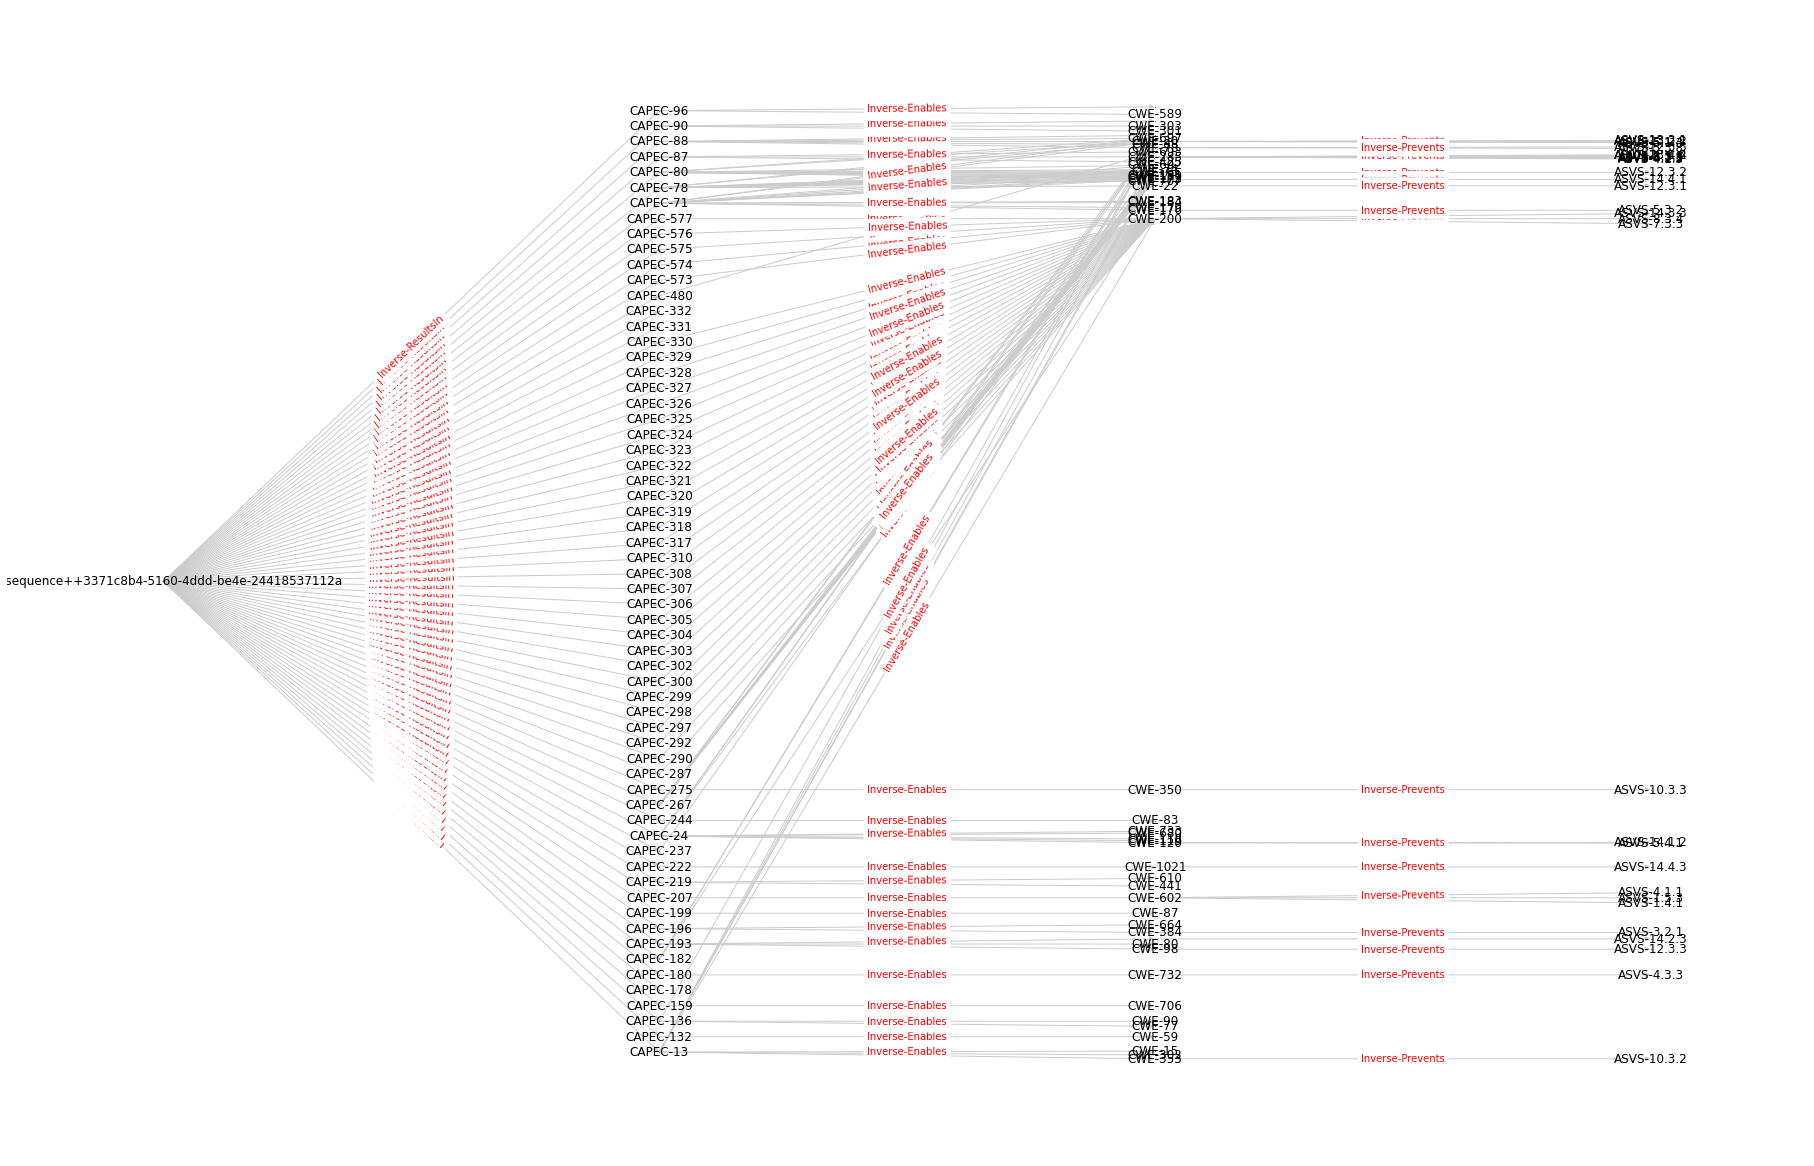

In [11]:
mt.show_tree(working_graph)